# Анализ поведения пользователей в мобильном приложении.

В данной работе нужно будет изучить поведение пользователей мобильного приложения по продаже продуктов питания. Сначала подготовим данные для дальнейшего анализа, затем изучим их, после изучим воронку продаж и проанализируем результаты A/A/B-эксперимента по изменению шрифта во всем приложении.

1. [Загрузка данных и ознакомление с ними](#start)
2. [Подготовка данных к дальнейшему анализу](#preprocessing)
    
3. [Изучение и проверка данных](#analiz)
    * [Подсчет количества всех событий](#cnt)
    * [Подсчет количества пользователей](#users)
    * [Сколько в среднем событий приходится на одного пользователя](#mean)
    * [Определение временного периода](#time)
    * [Определение сколько событий и пользователей потеряли, отбросив старые данные](#poteri)
    * [Анализ пользователей по группам](#group)
    
4. [Изучение воронки событий](#voronka)
    * [Определение частоты каждого события](#share)
    * [Подсчет количества пользователей, совершивших каждое из событий](#count)
    * [Подсчет доли пользователей, которые хоть раз совершали событие](#event)
    * [Предположение в каком порядке происходят события](#por)
    * [Подсчет доли пользователей, переходящих на следующий шаг воронки](#share_vor)
    * [ Подсчет доли пользователей, которые проходят путь от первого события до оплаты](#one)

5. [Изучение результатов эксперимента](#result)
    * [Подсчет количества пользователей в каждом эксперименте](#uniq)
    * [Проверка доли пользователей по событиям для каждой группы теста](#test)
    
6. [Вывод](#all)

## 1 Загрузка данных и ознакомление с ними
<a id="start"></a> 

In [57]:
#импортируем нужные библиотеки для дальнейшей работы
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth

In [58]:
df=pd.read_csv('logs_exp.csv',sep='\t') #открытие файла
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [59]:
df.info() #вывод общей информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Мы ознакомились с полученными данными. Пропусков значений в данных нет. Но нужно будет в следующем блоке изменить названия столбцов на змеиный регист , создать столбец с датой и временем и отдельно с датой. Так же мы проверим данные на наличие дубликатов.

## 2 Подготовка данных к дальнейшему анализу
<a id="preprocessing"></a> 

In [60]:
#изменение названия столбцов
df.columns=['event_name','device_id','event_time','exp_id']
df.head()

,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [61]:
#проверка данных на наличие дубликатов
print('Количество дубликатов:',df.duplicated().sum())
for i in df.columns:
    if df[i].duplicated().sum() > 0:
        print(i, df[i].duplicated().sum())
    else:
        'good'

Количество дубликатов: 413
event_name 244121
device_id 236575
event_time 67472
exp_id 244123


В данных есть повторяющиеся значения во всех столбцах и это нормально. Но есть дубликаты явные по всей таблице, их 413 штук. Их можно удалить, тк они занимают всего 0.169 % от всех данных.

In [62]:
#удаление явных дубликатов
df=df.drop_duplicates()

In [63]:
#проверка удаления явных дубликатов
print('Количество дубликатов:',df.duplicated().sum())

Количество дубликатов: 0


Теперь создадим два новых столбца. 
Один с датой и временем события, а другой с датой события.

In [64]:
#создание нового столбца с датой и временем события
df['time']=pd.to_datetime(df['event_time'],unit='s')
df.head()

,event_name,device_id,event_time,exp_id,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [65]:
#создание нового столбца с датой события
df['date']=df['time'].dt.floor('D')
df.head()

,event_name,device_id,event_time,exp_id,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Данные теперь готовы для дальнейшего анализа.

## 3 Изучение и проверка данных
<a id="analiz"></a> 

### 3.1 Подсчет количества всех событий
<a id="cnt"></a> 

In [66]:
#подсчет количества событий
df['event_name'].count()

243713

In [67]:
#вывод уникальных значений всех событий
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Всего 243 713 событий из них уникальные события: 
- MainScreenAppear (главный экран)
- PaymentScreenSuccessful (старница успешной оплаты)
- CartScreenAppear (корзина)
- OffersScreenAppear (экран предложения) 
- Tutorial (руководство)

### 3.2 Подсчет количества пользователей
<a id="users"></a> 

In [68]:
#подсчет количества уникальных пользователей
df['device_id'].nunique()

7551

Всего 7 551 уникальных пользователей.

### 3.3 Сколько в среднем событий приходится на одного пользователя
<a id="mean"></a> 

In [69]:
#создание таблицы с уникальными пользователями и их количеством событий
df_uniq_cnt=df.pivot_table(index='device_id', values='event_name', aggfunc='count')
df_uniq_cnt.head()

,event_name
device_id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


In [70]:
#определение сколько в среднем приходится событий на одного пользователя
df_uniq_cnt['event_name'].mean()

32.27559263673685

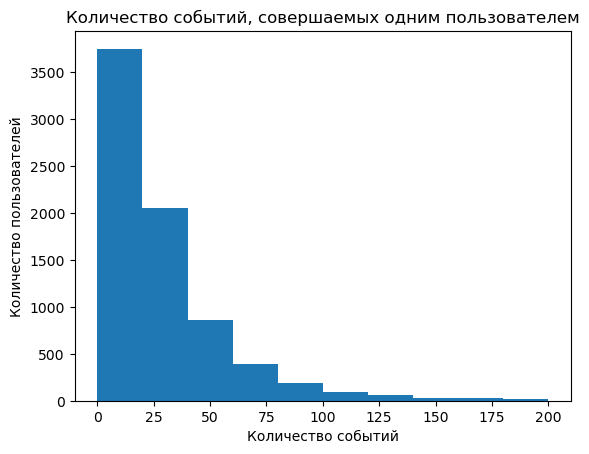

In [71]:
#построение гистограммы 
plt.hist(df_uniq_cnt, bins=10, range=(0,200))
plt.title('Количество событий, совершаемых одним пользователем')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

Из расчета среднего видно, что в среднем пользователь совершает 32 события в мобильном приложении.
А по гистограмме видно, что люди чаще всего совершают от 1 до 40 событий.

### 3.4 Определение временного периода
<a id="time"></a> 

In [72]:
#определение минимальной даты
df['date'].min()

Timestamp('2019-07-25 00:00:00')

In [73]:
#определение максимальной даты
df['date'].max()

Timestamp('2019-08-07 00:00:00')

В итоге получается, что у нас есть данные за период с 25 июля 2019 года по 7 августа 2019 года.

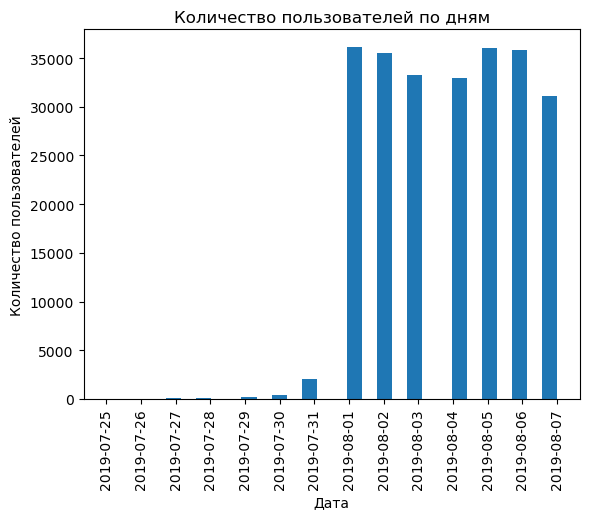

In [74]:
#построение гистограммы для определения полноты данных по датам
plt.hist(df['date'], bins=30)
plt.xticks(df['date'].sort_values().unique(),rotation=90)
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

По графику теперь видно, что у нас одинаково полные данные есть за период с 1 августа 2019 года по 7 августа 2019 года.

### 3.5 Определение сколько событий и пользователей потеряли, отбросив старые данные
<a id="poteri"></a> 

In [75]:
#создание новой таблицы с данным с 2019-08-01 по 2019-08-07
df_new=df.query('date >="2019-08-01"').reset_index(drop=True)
df_new.head()

,event_name,device_id,event_time,exp_id,time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [76]:
#подсчет количества потерь событий после удаления старых данных
df['event_name'].count()-df_new['event_name'].count()

2826

In [77]:
#расчет доли потерь в %
100-(df_new['event_name'].count()*100/df['event_name'].count())

1.1595606307418933

In [78]:
#подсчет количетсва потерь уникальных пользователей после удаления старых данных
df['device_id'].nunique()-df_new['device_id'].nunique()

17

In [79]:
#расчет доли потерь в %
100-(df_new['device_id'].nunique()*100/df['device_id'].nunique())

0.22513574361012445

В итоге мы потеряли 2 826 событий и 17 пользователей, что не значительно по отношению ко всем данным.

### 3.6 Анализ пользователей по группам
<a id="group"></a> 

In [80]:
#подсчет количества уникальных пользователей в эксперименте 246
id_a=df_new.query('exp_id == 246')
id_a['device_id'].nunique()

2484

In [81]:
#подсчет количества уникальных пользователей в эксперименте 247
id_aa=df_new.query('exp_id == 247')
id_aa['device_id'].nunique()

2513

In [82]:
#подсчет количества уникальных пользователей в эксперименте 248
id_b=df_new.query('exp_id == 248')
id_b['device_id'].nunique()

2537

Теперь посмотрим есть ли пользователи, которые вошли в какую-то еще группу

In [83]:
#проверка пользователей, которые могли попасть в несколько групп 
df_new.groupby('device_id').agg({'exp_id':'nunique'}).query('exp_id > 1') 

,exp_id
device_id,


В итоге получается, что у нас нет пользователей, которые попали еще в другие группы, поэтому можем спокойно переходить к дальнейшему анализу данных.

## 4 Изучение воронки событий
<a id="voronka"></a> 

### 4.1 Определение частоты каждого события
<a id="share"></a> 

In [84]:
#создание таблицы для подсчета частоты события 
event=df_new.pivot_table(index='event_name', values='device_id', aggfunc='count').sort_values(by='device_id', ascending=False)
event

,device_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Из этой таблицы видно, что чаще всего люди заходят на главный экран (MainScreenAppear), затем 39.5% из них переходят на экран предложений(OffersScreenAppear), далее пользователи преходят в корзину(CartScreenAppear) и только 33 918 человек переходят на страницу успешной оплаты(PaymentScreenSuccessful). В руководство заходило всего 1 005 пользователей.

### 4.2 Подсчет количества пользователей, совершивших каждое из событий
<a id="count"></a> 

In [85]:
#создание новой таблицы 
ev_vse=df_new.pivot_table(index='device_id',columns='event_name', values='date', aggfunc='count').reset_index()
ev_vse.head(10)

event_name,device_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,6888746892508752,NaN,1.0,NaN,NaN,NaN
1,6909561520679493,1.0,2.0,1.0,1.0,NaN
2,6922444491712477,8.0,19.0,12.0,8.0,NaN
3,7435777799948366,NaN,6.0,NaN,NaN,NaN
4,7702139951469979,5.0,40.0,87.0,5.0,NaN
5,8486814028069281,4.0,4.0,2.0,NaN,NaN
6,8740973466195562,NaN,8.0,1.0,NaN,NaN
7,9841258664663090,8.0,10.0,8.0,2.0,1.0
8,12692216027168046,NaN,7.0,3.0,NaN,NaN
9,15708180189885246,38.0,27.0,38.0,23.0,NaN


In [86]:
#подсчет уникальных пользователей
uniq=ev_vse['device_id'].nunique()
uniq

7534

In [87]:
#удаление пропусков и подсчет уникальных пользователей, совершавших каждое из событий
ev_vse=ev_vse.dropna().reset_index(drop=True)
ev_vse['device_id'].nunique()

466

Данный анализ говорит, что только 466 уникальных пользователей совершили каждое из событий из 7 534 уникальных пользователей, принявших участие в А/А/В-тесте.

### 4.3 Подсчет доли пользователей, которые хоть раз совершали событие
<a id="event"></a> 

In [88]:
#создание сводной таблицы
event_uniq= (df_new.pivot_table(index='event_name', values='device_id', aggfunc='nunique')
             .sort_values(by='device_id', ascending=False)
            )

In [89]:
#создание нового столбца, который покажет долю пользователей, которые хоть раз совершали событие
event_uniq['share']=((event_uniq['device_id']/uniq)*100).round(2)
event_uniq.reset_index()

,event_name,device_id,share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


### 4.4 Предположение в каком порядке происходят события
<a id="por"></a> 

Проанализировав данные можно предположить, что сначала люди заходят на главную страницу мобильного приложения(Main Screen Appear), затем переходят на экран предложения(Offers Screen Appear), затем в корзину (Cart Screen Appear), а после оплаты они попадают на страницу успешной оплаты (Payment Screen Successful). В руководства люди заходят редко и это может произойти в любой момент, поэтому дальнейшую воронку событий можно сделать без этого события.

### 4.5 Подсчет доли пользователей, переходящих на следующий шаг воронки
<a id="share_vor"></a> 

In [90]:
#создание таблицы без события tutorial
event_uniq=event_uniq.query('event_name != "Tutorial"')
event_uniq

,device_id,share
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97


In [91]:
#написание кода для создания диаграммы, показывающей долю пользователей, переходящих на следующее событие 
fig = go.Figure(go.Funnel(
    #определение параметра у
    y =['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
    #определение параметра х
    x = event_uniq['device_id'],
    #определение информации, которая будет выводиться, нас интересует процентное отношение последующего события к пердыдущему
    textinfo = 'value+percent previous',
    #настройка ширины линии
    connector = {'line': {'width': 0.2}})
    )
fig.update_layout(title='Доля пользователей, переходящих с одного события на следующее') 
fig.show()

По диаграмме видно , что 38% пользователей отсеиваются на первом событии и не делают следующий шаг(самый большой показатель отсеивания). После второго события отсеивается 19% пользователей, а из этих пользователей только 5% не переходят на страницу успешной оплаты заказа, то есть передумывают совершать покупку или у них возникла какая-то ошибка при оплате. 

### 4.6 Подсчет доли пользователей, которые проходят путь от первого события до оплаты
<a id="one"></a> 

In [92]:
#делаем срез данных
way=df_new.query('event_name != "Tutorial"')

In [93]:
#построение новой таблицы 
way=way.pivot_table(index='device_id',columns='event_name', values='time', aggfunc='min').reset_index()
way.head()

event_name,device_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
1,6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
2,6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
3,7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
4,7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


In [94]:
#вывод количества пользователей с первого события 
cnt_1=way['MainScreenAppear'].count()
cnt_1

7419

In [95]:
#удаление строк с пропусками и создание новой переменной
way1=way.dropna().reset_index(drop=True)
way1.head()

event_name,device_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
1,6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
2,7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
3,9841258664663090,2019-08-03 10:52:15,2019-08-03 10:47:59,2019-08-03 10:49:42,2019-08-03 17:57:27
4,15708180189885246,2019-08-01 11:06:19,2019-08-01 16:08:23,2019-08-01 05:38:55,2019-08-01 11:06:19


Проанализировав первые строки таблицы видно, что не все пользователи идут по тому пути, который мы предположили. Но мы все равно посчитаем, сколько людей дошли от первого события до оплаты по нашему предположенному пути.

In [96]:
#делаем срез данных по выбранному нами пути.
event_4=way1.query('(OffersScreenAppear > MainScreenAppear) and (CartScreenAppear> OffersScreenAppear) and (PaymentScreenSuccessful> CartScreenAppear)')
event_4.head()

event_name,device_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
3,9841258664663090,2019-08-03 10:52:15,2019-08-03 10:47:59,2019-08-03 10:49:42,2019-08-03 17:57:27
8,29094035245869447,2019-08-02 13:15:22,2019-08-02 13:13:24,2019-08-02 13:13:43,2019-08-02 15:23:05
28,84107839139059565,2019-08-03 15:15:43,2019-08-03 15:13:41,2019-08-03 15:15:17,2019-08-03 15:16:18
44,116683309485180923,2019-08-02 07:18:54,2019-08-01 19:42:38,2019-08-01 19:47:36,2019-08-02 07:20:44
47,133486548927612375,2019-08-03 10:30:25,2019-08-03 10:28:43,2019-08-03 10:29:47,2019-08-04 10:23:26


In [97]:
#подсчет количества пользователей, которые прошли весь пути, который мы предположили.
cnt_4=event_4['device_id'].count()
cnt_4

454

In [98]:
#расчет доли пользователей прошедших от первого события до оплаты по нашему предполагаемому пути.
shape= ((cnt_4/cnt_1)*100).round(2)
shape

6.12

Из данного расчета мы видим, что только 6.12% пользователей проходят весь, нами предполагаемый, путь от посещения главное страницы до перехода на экран об успешной оплате. Что подтверждает то, что не все пользователи идут по предполагаемому нами пути.

## 5 Изучение результатов эксперимента
<a id="result"></a> 

### 5.1 Подсчет количества пользователей в каждом эксперименте
<a id="uniq"></a> 

In [99]:
#подсчет количества уникальных пользователей в эксперименте 246
cnt_a=id_a['device_id'].nunique()
cnt_a

2484

In [100]:
#подсчет количества уникальных пользователей в эксперименте 246
cnt_aa=id_aa['device_id'].nunique()
cnt_aa

2513

Количество пользователей в А/А-тесте различается на 1,15%, что допустимо.

In [101]:
#подсчет количества уникальных пользователей в эксперименте 246
cnt_b=id_b['device_id'].nunique()
cnt_b

2537

### 5.2 Проверка доли пользователей по событиям для каждой группы теста
<a id="test"></a> 

In [102]:
#создание функции для вывода таблицы с расчетом доли пользователей по событиям и группам теста
def events_shape(event):
    #делаем срез данных по названию события
    ev= df_new[df_new['event_name']== event]
    #создаем сводную таблицу с расчетом уникальных пользователей по группам по этому событию
    cnt_ev= ev.pivot_table(index=['event_name','exp_id'], values='device_id', aggfunc='nunique').reset_index()
    #создаем сводную таблицу с расчетом уникальных пользователей по группам
    cnt_all=df_new.pivot_table(index='exp_id', values='device_id', aggfunc='nunique').reset_index()
    #переименование столбцов
    cnt_ev=cnt_ev.rename(columns={'device_id':'cnt_ev_id'})
    cnt_all=cnt_all.rename(columns={'device_id':'cnt_all_id'})
    #объединение двух сводных таблиц в одну 
    cnt= cnt_ev.merge(cnt_all, left_on='exp_id', right_on='exp_id')
    
    #добавление строки с данными из группы 246 и 247 
    cnt.loc[3, 'event_name']= event
    cnt.loc[3,'exp_id']= 'a+a1'
    cnt.loc[3,'cnt_ev_id']=cnt.loc[0,'cnt_ev_id']+cnt.loc[1,'cnt_ev_id']
    cnt.loc[3,'cnt_all_id']=cnt.loc[0,'cnt_all_id']+cnt.loc[1,'cnt_all_id']
    
    #создание отдельного столбца с расчетом доли 
    cnt['shape']= ((cnt['cnt_ev_id']/cnt['cnt_all_id'])*100).round(2)
    
    return cnt

In [103]:
#вывод долей по группам по самому популярному событию
msa=events_shape('MainScreenAppear')
msa

,event_name,exp_id,cnt_ev_id,cnt_all_id,shape
0,MainScreenAppear,246.0,2450.0,2484.0,98.63
1,MainScreenAppear,247.0,2476.0,2513.0,98.53
2,MainScreenAppear,248.0,2493.0,2537.0,98.27
3,MainScreenAppear,a+a1,4926.0,4997.0,98.58


Здесь мы видим, что доли пользователей совершивших событие "Просмотр главной страницы" практически одинаковы, у них есть несущественные различия. 

In [104]:
#вывод долей по событию "Просмотр экрана предложений"
osa=events_shape('OffersScreenAppear')
osa

,event_name,exp_id,cnt_ev_id,cnt_all_id,shape
0,OffersScreenAppear,246.0,1542.0,2484.0,62.08
1,OffersScreenAppear,247.0,1520.0,2513.0,60.49
2,OffersScreenAppear,248.0,1531.0,2537.0,60.35
3,OffersScreenAppear,a+a1,3062.0,4997.0,61.28


In [105]:
#вывод долей по событию "Просмотр корзины"
csa=events_shape('CartScreenAppear')
csa

,event_name,exp_id,cnt_ev_id,cnt_all_id,shape
0,CartScreenAppear,246.0,1266.0,2484.0,50.97
1,CartScreenAppear,247.0,1238.0,2513.0,49.26
2,CartScreenAppear,248.0,1230.0,2537.0,48.48
3,CartScreenAppear,a+a1,2504.0,4997.0,50.11


In [106]:
#вывод долей по событию "Переход на страницу об успешной оплате"
pss=events_shape('PaymentScreenSuccessful')
pss

,event_name,exp_id,cnt_ev_id,cnt_all_id,shape
0,PaymentScreenSuccessful,246.0,1200.0,2484.0,48.31
1,PaymentScreenSuccessful,247.0,1158.0,2513.0,46.08
2,PaymentScreenSuccessful,248.0,1181.0,2537.0,46.55
3,PaymentScreenSuccessful,a+a1,2358.0,4997.0,47.19


In [107]:
#вывод долей по событию "Просмотр руководства"
tut=events_shape('Tutorial')
tut

,event_name,exp_id,cnt_ev_id,cnt_all_id,shape
0,Tutorial,246.0,278.0,2484.0,11.19
1,Tutorial,247.0,283.0,2513.0,11.26
2,Tutorial,248.0,279.0,2537.0,11.00
3,Tutorial,a+a1,561.0,4997.0,11.23


Проанализировав все таблицы с расчетом долей пользователей по группам и событиям, оценив их визуально, можно сделать вывод, то различия в долях есть, но они не критичны, поэтому разбиение на группы корректно.

Но чтобы это подтвердить проверим гипотезу.
Н0-статистически значимых различий в долях пользователей по событиям и группам нет. Н1- статистически значимые различия в долях пользователей по событиям и группам есть.

Так как мы будем проверять Н0 много раз по каждой группе и каждому событию, то сделаем корректировку значения уровня значимости по методу Шидака, чтобы снизить вероятность ложно позитивного результата.

In [108]:
#создание функции для проверки гипотезы
def ztest(alpha, cnt_ev_id1, cnt_ev_id2, cnt_all_1, cnt_all_2):
    # скорректированное значение требуемого уровня значимости по методу Шидака для произведенных 20 сравнений 
    shidak=1-(1-alpha)**(1/20)
    # пропорция успехов в первой группе:
    p1 = cnt_ev_id1/cnt_all_1
    # пропорция успехов во второй группе:
    p2 = cnt_ev_id2/cnt_all_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (cnt_ev_id1 + cnt_ev_id2) / (cnt_all_1 + cnt_all_2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/cnt_all_1 + 1/cnt_all_2))
    # задаем стандартное нормальное распределение (среднее 0, стандартное отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < shidak:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [109]:
#проверка гипотезы для группы 246 и 247 по каждому событию
ztest(0.05, msa['cnt_ev_id'].loc[0], msa['cnt_ev_id'].loc[1],msa['cnt_all_id'].loc[0],msa['cnt_all_id'].loc[1])
ztest(0.05, osa['cnt_ev_id'].loc[0], osa['cnt_ev_id'].loc[1],osa['cnt_all_id'].loc[0],osa['cnt_all_id'].loc[1])
ztest(0.05, csa['cnt_ev_id'].loc[0], csa['cnt_ev_id'].loc[1],csa['cnt_all_id'].loc[0],csa['cnt_all_id'].loc[1])
ztest(0.05, pss['cnt_ev_id'].loc[0], pss['cnt_ev_id'].loc[1],pss['cnt_all_id'].loc[0],pss['cnt_all_id'].loc[1])
ztest(0.05, tut['cnt_ev_id'].loc[0], tut['cnt_ev_id'].loc[1],tut['cnt_all_id'].loc[0],tut['cnt_all_id'].loc[1])

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [110]:
#проверка гипотезы для группы 246 и 248 по каждому событию
ztest(0.05, msa['cnt_ev_id'].loc[0], msa['cnt_ev_id'].loc[2],msa['cnt_all_id'].loc[0],msa['cnt_all_id'].loc[2])
ztest(0.05, osa['cnt_ev_id'].loc[0], osa['cnt_ev_id'].loc[2],osa['cnt_all_id'].loc[0],osa['cnt_all_id'].loc[2])
ztest(0.05, csa['cnt_ev_id'].loc[0], csa['cnt_ev_id'].loc[2],csa['cnt_all_id'].loc[0],csa['cnt_all_id'].loc[2])
ztest(0.05, pss['cnt_ev_id'].loc[0], pss['cnt_ev_id'].loc[2],pss['cnt_all_id'].loc[0],pss['cnt_all_id'].loc[2])
ztest(0.05, tut['cnt_ev_id'].loc[0], tut['cnt_ev_id'].loc[2],tut['cnt_all_id'].loc[0],tut['cnt_all_id'].loc[2])

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [111]:
#проверка гипотезы для группы 247 и 248 по каждому событию
ztest(0.05, msa['cnt_ev_id'].loc[1], msa['cnt_ev_id'].loc[2],msa['cnt_all_id'].loc[1],msa['cnt_all_id'].loc[2])
ztest(0.05, osa['cnt_ev_id'].loc[1], osa['cnt_ev_id'].loc[2],osa['cnt_all_id'].loc[1],osa['cnt_all_id'].loc[2])
ztest(0.05, csa['cnt_ev_id'].loc[1], csa['cnt_ev_id'].loc[2],csa['cnt_all_id'].loc[1],csa['cnt_all_id'].loc[2])
ztest(0.05, pss['cnt_ev_id'].loc[1], pss['cnt_ev_id'].loc[2],pss['cnt_all_id'].loc[1],pss['cnt_all_id'].loc[2])
ztest(0.05, tut['cnt_ev_id'].loc[1], tut['cnt_ev_id'].loc[2],tut['cnt_all_id'].loc[1],tut['cnt_all_id'].loc[2])

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [112]:
#проверка гипотезы для группы  248 и a_a1 по каждому событию
ztest(0.05, msa['cnt_ev_id'].loc[2], msa['cnt_ev_id'].loc[3],msa['cnt_all_id'].loc[2],msa['cnt_all_id'].loc[3])
ztest(0.05, osa['cnt_ev_id'].loc[2], osa['cnt_ev_id'].loc[3],osa['cnt_all_id'].loc[2],osa['cnt_all_id'].loc[3])
ztest(0.05, csa['cnt_ev_id'].loc[2], csa['cnt_ev_id'].loc[3],csa['cnt_all_id'].loc[2],csa['cnt_all_id'].loc[3])
ztest(0.05, pss['cnt_ev_id'].loc[2], pss['cnt_ev_id'].loc[3],pss['cnt_all_id'].loc[2],pss['cnt_all_id'].loc[3])
ztest(0.05, tut['cnt_ev_id'].loc[2], tut['cnt_ev_id'].loc[3],tut['cnt_all_id'].loc[2],tut['cnt_all_id'].loc[3])

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы проверили гипотезу по всем группам и событиям. В итоге мы можем точно теперь сказать, что Н0 нельзя отвергать, значит статистически значимых различий между долями нет у групп по событиям.

А из этого можно сделать вывод, что изменение шрифта не повлияло на пользователей.

## 6 Вывод
<a id="all"></a> 

В данной работе мы изучили и подготовили данные для дальнейшего анализа, изучили воронку событий и результаты эксперимента.

В первой и второй части мы ознакомились с таблицей, изменили названия столбцов на змеиный регистр, создали два столбца с датой и датой и временем, избавились от явных дубликатов.

В третьей части мы узнали, что в среднем на одного пользователя приходится 32 события. Был изучен временной промежуток и оставлены только полные данные за период с 25 июля 2019 года по 7 августа 2019 года. В итоге у нас осталось для анализа 240 887 событий, которые совершили 7 534 пользователя. Аномальные пользователи во всех трех группах отсутствуют.

В четвертой части работы была изучена и составлена воронка событий. Сначала мы определили частоту совершения каждого события и выявили, что чаще всего пользователи совершают событие MainScreenAppear, потом идет событие OffersScreenAppear, затем CartScreenAppear, затем PaymentScreenSuccessful и меньше всего люди делают событие Tutorial.

Был сделан подсчет пользователей, которые совершили каждое событие. Благодаря ему, мы выяснили, что всего 466 пользователей из 7 534 сделали это. Это всего лишь 6,2% всех пользователей.

Проанализировав полученные данные по подсчету частоты каждого события и по долям пользователей, которые хоть раз совершали событие, была предположена такая воронка событий:
1) (Main Screen Appear) пользователь сначала заходит на главную страницу
2) Затем открывает  (Offers Screen Appear) страницу с предложениями
3) Переходит в (Cart Screen Appear) корзину
4) После оплаты попадает на (Payment Screen Successful) страницу успешной оплаты.

По диаграмме, показывающей долю пользователей, переходящих на следующее событие видно, что 38% пользователей отсеиваются на первом событии и не делают следующий шаг(самый большой показатель отсеивания). Возможно нужно сделать более привлекательной главную страницу, чтоб уменьшить процент отсеивания людей. После второго события отсеивается 19% пользователей, а из этих пользователей только 5% не переходят на страницу успешной оплаты заказа, что скорее всего связано с тем, что пользователь передумал совершать покупку или у него возникла ошибка при оплате заказа.

Рассчитав долю пользователей, которые проходят путь от первого события до оплаты по выбранному нами пути, выяснили, что только 6.12% пользователей проходят весь путь от посещения главное страницы до перехода на экран об успешной оплате. Это говорит о том, что не все люди проходят по той воронке событий, которая была предположена ( это около 0.08% пользователей).

В пятой части были изучены результаты эксперимента по изменению шрифта. У нас есть контрольные группы(246 и 247) и  экспериментальная группа 248. Были созданы функции: 1) Первая для создания таблиц, в которых показана доля пользователей по группам и определенному событию. 2) Вторая функция проверяет гипотезу. 

Гипотеза Н0- статистически значимых различий в долях пользователей по событиям и группам нет. Н1- статистически значимые различия в долях пользователей по событиям и группам есть.

Для проверки гипотезы был скорректирован уровень значимости по методу Шидака, чтобы снизить вероятность ложно позитивного результата, так как гипотезу мы проверили 20 раз. 

Итог проверки гипотезы: Н0 была подтверждена. Действительно статистически значимых различий в долях пользователей по событиям и группам теста нет. Значит изменение шрифта никак не повлияло на действия пользователей. 